In [1]:
import sys
sys.path.append('/home/changqi/dmpbbo')
import rosbag
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import os
import time
import dmpbbo.json_for_cpp as jc
from dmpbbo.dmps.Dmp import Dmp
from dmpbbo.dmps.Trajectory import Trajectory
from dmpbbo.functionapproximators.FunctionApproximatorRBFN import FunctionApproximatorRBFN

In [2]:
bag_path = "/home/changqi/franka/catkin_ws/src/franka_interactive_controllers/kinesthetic_rosbag/test/demo_2023-08-29-15-41-36.bag"
bag = rosbag.Bag(bag_path)
topic_ =  '/franka_state_controller/joint_states'# ['/franka_state_controller/F_ext', '/franka_state_controller/O_T_EE', '/franka_state_controller/O_T_FL', '/franka_state_controller/joint_states', '/tf']
msg_nums = bag.get_type_and_topic_info()[1][topic_][1]
# [time, y1, ... y7, yd1, ... yd7]
if topic_ == '/franka_state_controller/O_T_EE':
    traj_array = np.zeros((msg_nums, 8))
elif topic_ == '/franka_state_controller/joint_states':
    traj_array = np.zeros((msg_nums, 15))
print(traj_array.shape)
start_time = 0
# print(start_time)
for i, (topic, msg, t) in enumerate(bag.read_messages(topics=[topic_])):
    if i == 0:
        start_time = msg.header.stamp.secs + (msg.header.stamp.nsecs * 10e-10)
        com_time = 0
    else:
        com_time = msg.header.stamp.secs + (msg.header.stamp.nsecs * 10e-10) - start_time

    traj_array[i, 0] = com_time

    # break # TODO: implement cartesion traj
    if topic_ == '/franka_state_controller/O_T_EE':
        traj_array[i, 1] = msg.pose.position.x
        traj_array[i, 2] = msg.pose.position.y
        traj_array[i, 3] = msg.pose.position.z
        traj_array[i, 4] = msg.pose.orientation.x
        traj_array[i, 5] = msg.pose.orientation.y
        traj_array[i, 6] = msg.pose.orientation.z
        traj_array[i, 7] = msg.pose.orientation.w
    elif topic_ == '/franka_state_controller/joint_states':
        traj_array[i, 1:8] = msg.position
        traj_array[i, 8:15] = msg.velocity

bag.close()

(21056, 15)


In [3]:
print(traj_array[0,:])

[ 0.00000000e+00  1.74195715e-03 -7.91027395e-01 -6.05215338e-04
 -2.34550544e+00 -3.52999597e-03  1.57816786e+00  7.92787348e-01
  1.85734619e-04  2.58728917e-04 -9.14451589e-04 -2.43827521e-05
 -3.07439171e-04 -8.08244383e-05  1.01560920e-03]


In [4]:
# save traj_array to txt
save_path = '/home/changqi/franka/catkin_ws/src/franka_interactive_controllers/scripts/dmp_exp'
np.savetxt(f'{save_path}/traj_array.txt', traj_array)
# load traj_array from txt
traj_array = np.loadtxt(f'{save_path}/traj_array.txt')
print(traj_array.shape)

(21056, 15)


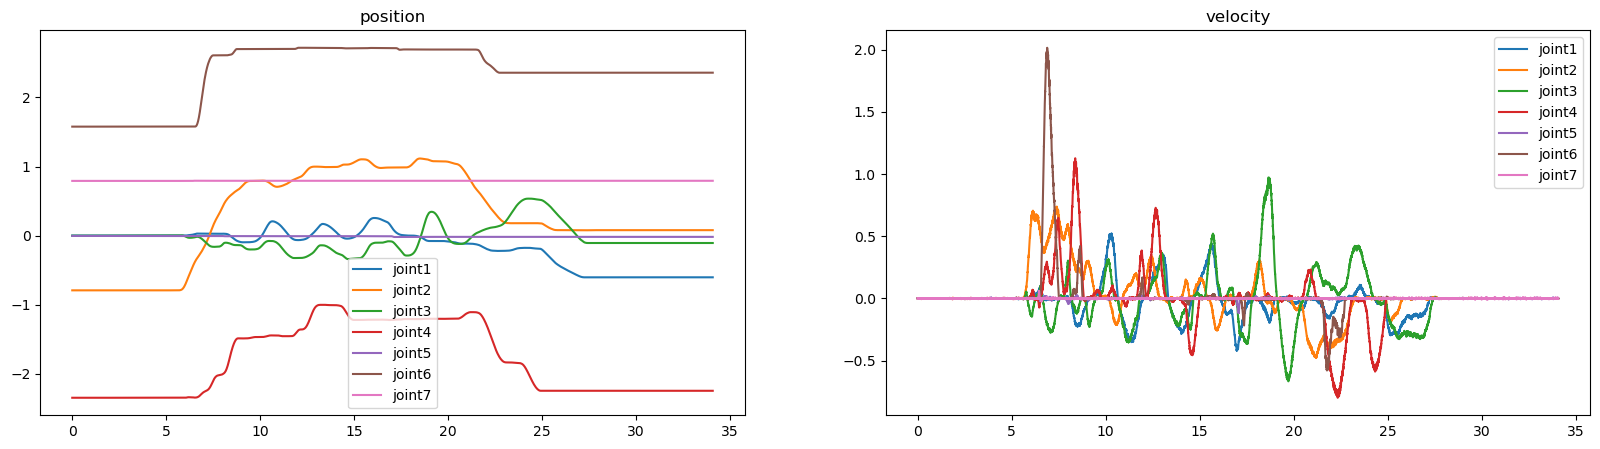

In [5]:
if topic_ == '/franka_state_controller/joint_states':
    fig, axs = plt.subplots(1, 2, figsize=(20, 5))
    for ax in range(2):
        for joint in range(7):
            axs[ax].plot(traj_array[:, 0], traj_array[:, 7*ax+joint+1], label=f'joint{joint+1}')
            axs[ax].legend()
            if ax == 0:
                axs[ax].set_title('position')
            else:
                axs[ax].set_title('velocity')
elif topic_ == '/franka_state_controller/O_T_EE':
    fig, axs = plt.subplots(1, 1, figsize=(20, 5))
    for pose in range(7):
        axs.plot(traj_array[:, 0], traj_array[:, pose+1], label=f'pose{pose+1}')
        axs.legend()
        axs.set_title('pose')

plt.show()

In [8]:
output_dir = f'{save_path}/dmp_output'
os.makedirs(output_dir, exist_ok=True)
traj = Trajectory.loadtxt(f'{save_path}/traj_array.txt')
filename_traj = Path(output_dir, "dmp_pre_traj.txt")
traj.savetxt(filename_traj)
num_dims = traj.dim
peak_to_peak = np.ptp(traj.ys, axis=0)
mean_absolute_errors = []
n_bfs = 200
n_bfs_list = list(range(199, n_bfs+1)) # why 3?
show, save_fig = False, True
print(num_dims)

ydds is None
7


In function SigmoidSystem, Ks is too close to N_0s. This may lead to errors during numerical integration. Recommended solution: choose a lower magnitude for the maximum rate of change (currently it is -15.0) 
Training DMP with 199 basis functions

               Number of basis functions: 199
MAE between demonstration and reproduced: 0.014145237257914793
                           Range of data: [0.85881867 1.9080428  0.87439032 1.34493703 0.01603818 1.14114008
 0.00237105]

In function SigmoidSystem, Ks is too close to N_0s. This may lead to errors during numerical integration. Recommended solution: choose a lower magnitude for the maximum rate of change (currently it is -15.0) 
Training DMP with 200 basis functions

               Number of basis functions: 200
MAE between demonstration and reproduced: 0.014499867001191435
                           Range of data: [0.85881867 1.9080428  0.87439032 1.34493703 0.01603818 1.14114008
 0.00237105]



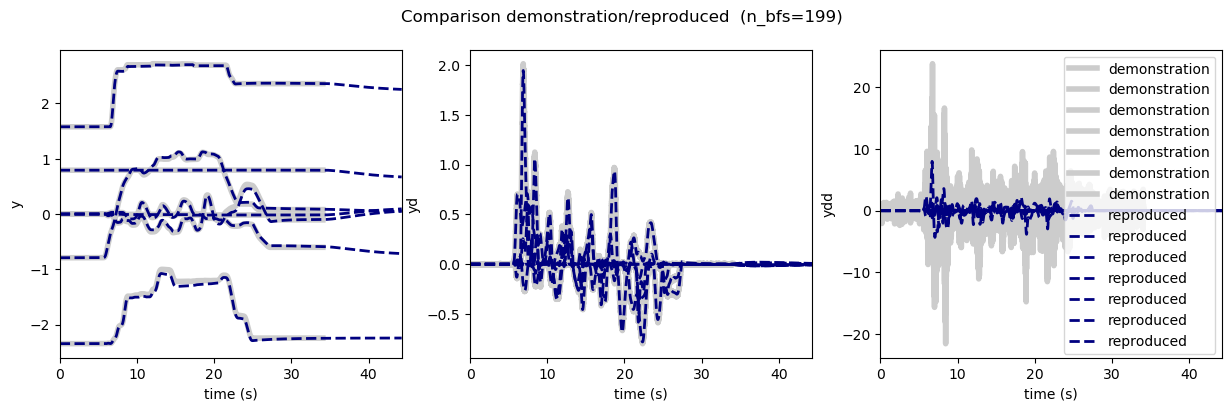

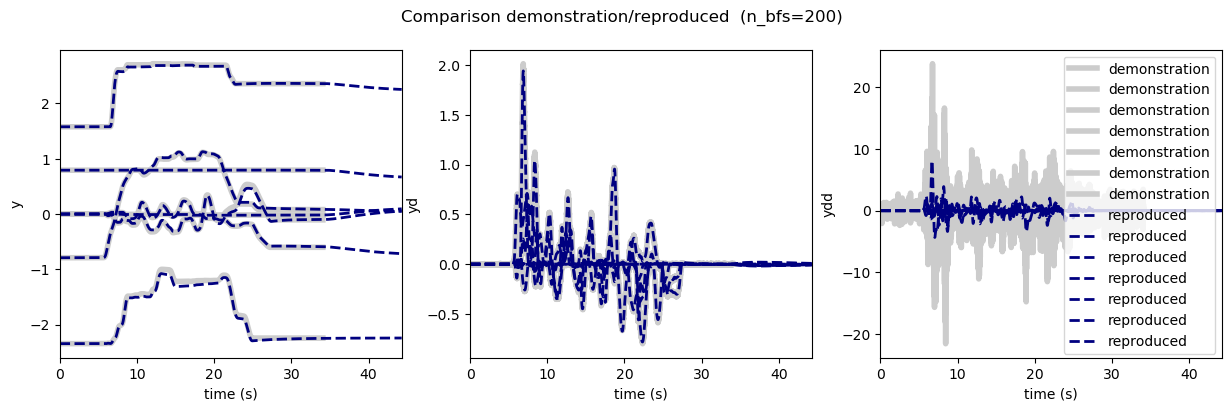

In [9]:
for n_bfs in n_bfs_list:
    function_apps = [FunctionApproximatorRBFN(n_bfs, 0.7) for _ in range(num_dims)]
    dmp = Dmp.from_traj(traj, function_apps, dmp_type="KULVICIUS_2012_JOINING")
    dmp.set_selected_param_names("weights")

    d = output_dir
    filename = Path(d,f"dmp_trained_{n_bfs}_bfs.json")
    print(f"Training DMP with {n_bfs} basis functions")
    jc.savejson(filename, dmp)
    jc.savejson_for_cpp(Path(d,f"dmp_trained_{n_bfs}_for_cpp.json"), dmp)

    ts = traj.ts
    xs_ana, xds_ana, _, _ = dmp.analytical_solution(ts)
    traj_reproduced_ana = dmp.states_as_trajectory(ts, xs_ana, xds_ana)

    mae = np.mean(abs(traj.ys - traj_reproduced_ana.ys))
    mean_absolute_errors.append(mae)
    print()
    print(f"               Number of basis functions: {n_bfs}")
    print(f"MAE between demonstration and reproduced: {mae}")
    print(f"                           Range of data: {peak_to_peak}")
    print()

    ################################################
    # Integrate DMP

    tau_exec = 1.3 * traj.duration
    dt = 0.01
    n_time_steps = int(tau_exec / dt)
    ts = np.zeros([n_time_steps, 1])
    xs_step = np.zeros([n_time_steps, dmp.dim_x])
    xds_step = np.zeros([n_time_steps, dmp.dim_x])

    x, xd = dmp.integrate_start()
    xs_step[0, :] = x
    xds_step[0, :] = xd
    for tt in range(1, n_time_steps):
        ts[tt] = dt * tt
        xs_step[tt, :], xds_step[tt, :] = dmp.integrate_step(dt, xs_step[tt - 1, :])

    traj_reproduced = dmp.states_as_trajectory(ts, xs_step, xds_step)

    if show or save_fig:
        ################################################
        # Plot results

        # h, axs = dmp.plot(dmp.tau,ts,xs_step,xds_step)
        # fig.canvas.set_window_title(f'Step-by-step integration (n_bfs={n_bfs})')
        # fig.savefig(Path(args.output_directory,f'dmp_trained_{n_bfs}.png'))

        h_demo, axs = traj.plot()
        h_repr, _ = traj_reproduced.plot(axs)
        d = "demonstration"
        plt.setp(h_demo, linestyle="-", linewidth=4, color=(0.8, 0.8, 0.8), label=d)
        plt.setp(h_repr, linestyle="--", linewidth=2, color=(0.0, 0.0, 0.5), label="reproduced")
        plt.legend()
        plt.gcf().canvas.set_window_title(f"Comparison {d}/reproduced  (n_bfs={n_bfs})")
        plt.gcf().suptitle(f"Comparison {d}/reproduced  (n_bfs={n_bfs})")
        if save_fig:
            plt.gcf().savefig(Path(output_dir, f"trajectory_comparison_{n_bfs}.png"))


[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]
[0.12876964327529977, 0.07903888005765974, 0.06531541523539076, 0.06155878493628973, 0.05734195455911735, 0.050757991654479286, 0.045520786968656635, 0.04442127832161597, 0.04112918261004729, 0.03428366079557817, 0.03363074483173065, 0.03333515277110838, 0.029026346963190532, 0.025407884806095776, 0.02648808414537042, 0.02391787938456522, 0.02127380165793006, 0.021911997101681964, 0.021333313190889127, 0.021050223077303677, 0.01924272437991363, 0.01762859300789875, 0.019182131212888375, 0.014747328477546126, 0.016137548669332064, 0.01405059578188283, 0.013174537294207206, 0.01438754621539101, 0.012021279868610553, 0.011373653606106843, 0.012349463167307263, 0.012316809979581574, 0.01130565795324992, 0.010598584002084037, 0.010267686003519171, 0.012248046795889098, 0.0113182853000224, 0.01051827571549970

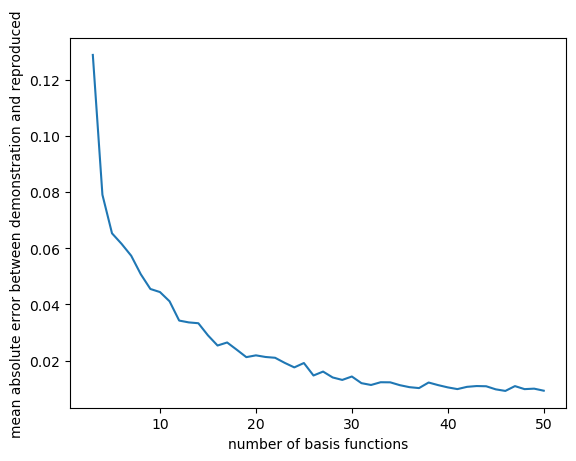

In [10]:
if len(n_bfs_list) > 1:
    # Plot the mean absolute error
    ax = plt.figure().add_subplot(111)
    print(n_bfs_list)
    print(mean_absolute_errors)
    ax.plot(n_bfs_list, mean_absolute_errors)
    ax.set_xlabel("number of basis functions")
    ax.set_ylabel("mean absolute error between demonstration and reproduced")
    filename = "mean_absolute_errors.png"
    plt.show()
